In [6]:
import mlflow
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [11]:
! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

Dataset URL: https://www.kaggle.com/datasets/pcbreviglieri/pneumonia-xray-images
License(s): Attribution 4.0 International (CC BY 4.0)




  0%|          | 0.00/1.14G [00:00<?, ?B/s]
  0%|          | 1.00M/1.14G [00:00<02:48, 7.26MB/s]
  0%|          | 5.00M/1.14G [00:00<01:02, 19.6MB/s]
  1%|          | 10.0M/1.14G [00:00<00:40, 29.9MB/s]
  1%|▏         | 15.0M/1.14G [00:00<00:35, 34.5MB/s]
  2%|▏         | 20.0M/1.14G [00:00<00:31, 37.7MB/s]
  2%|▏         | 25.0M/1.14G [00:00<00:29, 40.1MB/s]
  3%|▎         | 30.0M/1.14G [00:00<00:27, 42.9MB/s]
  3%|▎         | 35.0M/1.14G [00:00<00:26, 44.6MB/s]
  3%|▎         | 40.0M/1.14G [00:01<00:29, 40.1MB/s]
  4%|▍         | 44.0M/1.14G [00:01<00:30, 38.4MB/s]
  4%|▍         | 48.0M/1.14G [00:01<00:29, 39.3MB/s]
  5%|▍         | 53.0M/1.14G [00:01<00:28, 41.0MB/s]
  5%|▍         | 57.0M/1.14G [00:01<00:44, 26.4MB/s]
  5%|▌         | 62.0M/1.14G [00:01<00:38, 30.1MB/s]
  6%|▌         | 66.0M/1.14G [00:02<00:48, 23.6MB/s]
  6%|▌         | 69.0M/1.14G [00:02<00:50, 22.9MB/s]
  6%|▋         | 74.0M/1.14G [00:02<00:45, 25.0MB/s]
  7%|▋         | 77.0M/1.14G [00:02<00:45, 25.2MB/s]
 

In [95]:
import zipfile
zf = "pneumonia-xray-images.zip"
target_dir = "dataset/cnn/pneumonia_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [8]:
train_transform = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.Grayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [9]:
train_data = datasets.ImageFolder('dataset/cnn/pneumonia_revamped/train', transform=train_transform)
valid_data = datasets.ImageFolder('dataset/cnn/pneumonia_revamped/val', transform=test_transform)
test_data = datasets.ImageFolder('dataset/cnn/pneumonia_revamped/test', transform=test_transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 64, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 60 * 60, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 1), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [11]:
model = CNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
epochs = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=230400, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=1, bias=True)
    (6): Sigmoid()
  )
)

In [13]:
with mlflow.start_run():
    params = {
        "epochs": epochs,
        "learning_rate": 0.001,
        "batch_size": 16,
        "optimizer": "Adam",
        "loss_function": criterion.__class__.__name__,
    }
    
    mlflow.log_params(params)

In [14]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.float().to(device).view(-1, 1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    mlflow.log_metric("train_loss", epoch_loss, step=epoch)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')
    

Epoch 1/2, Loss: 0.1987
Epoch 2/2, Loss: 0.1030


In [15]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.float().to(device).view(-1, 1)
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
mlflow.log_metric("validation_accuracy", accuracy)
print(f'Validation Accuracy: {accuracy:.2f}%')

# Save the trained model to MLflow
mlflow.pytorch.log_model(model, "cnn_pneumonia_model")

Validation Accuracy: 96.15%


In [16]:
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.float().to(device).view(-1, 1)
        outputs = model(inputs)
        preds = (outputs > 0.5).float()
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

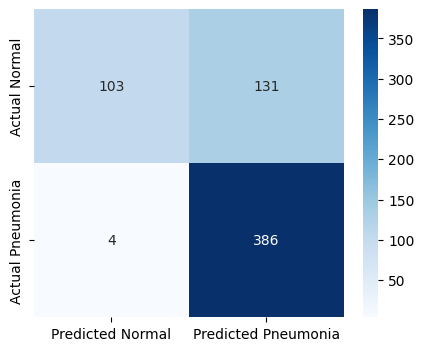

              precision    recall  f1-score   support

      NORMAL       0.96      0.44      0.60       234
   PNEUMONIA       0.75      0.99      0.85       390

    accuracy                           0.78       624
   macro avg       0.85      0.71      0.73       624
weighted avg       0.83      0.78      0.76       624



In [17]:
cm = confusion_matrix(true_labels, predictions)
cm_df = pd.DataFrame(cm, index=["Actual Normal", "Actual Pneumonia"], columns=["Predicted Normal", "Predicted Pneumonia"])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.show()


print(classification_report(true_labels, predictions, target_names=['NORMAL', 'PNEUMONIA']))

Conclusion
This project implements a CNN for pneumonia detection using chest X-rays, tracking performance with MLflow. The model achieved 78% accuracy after 2 epochs, and further training can improve performance.

